# Numpy version test on synthetic data

In this notebook we define the following functions:

|Function name| Description|
| -- | -- |
| `get_gmm_j` | Returns the $j^{th}$ Gaussian mixture model|
| `get_C_j` | Returns the $j^{th}$ GMM covariance matrix|
| `gmm_kernel` | Returns the sum of the $N_{GMM}$ Gaussian mixture models|
| `get_A_matrix` | Return the column-wise concatenated $A$ matrix|
| `compute_f_star` | Computes the $f^{*}$, the vector of stellar fluxes|
| `init_N_stars` | Initialize the locations of $N_stars$|
| `lnlike` | Compute the log likelihood|


These functions have the following inputs and outputs:

|Function name| Input| Output |
| -- | -- | -- |
| `get_gmm_j` | $x_j, y_j$, $C_j$ | $\mathcal{G_j}$|
| `get_C_j` | $\phi_{a,b,c,j}$ | $C_j$|
| `gmm_kernel` | $\mathcal{G_j}$, $z_j$| $\mathcal{K}$|
| `get_C_matrix` | $\sigma_r$, $N_{pix}$| $\mathsf{C}$|
| `get_A_matrix` | $\mathcal{K}$, $(x_c, y_c)$'s| $\mathsf{A}$|
| `get_f_star` | $\mathsf{A}$, $\mathsf{C}$, $\mathsf{d}$|$f^{*}$|
| `init_N_stars` | catalog *or* image| $(x_c,y_c)$| 
| `lnlike` | all parameters |log likelihood|

In [1]:
# %load ~/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def get_C_j(phi_a, phi_b, phi_c):
    '''Return the GMM covariance matrix given phi parameters'''
    v11 = np.exp(2.0*phi_a)
    v12 = phi_c*np.exp(phi_a)
    v22 = phi_c**2 + np.exp(2.0*phi_b)
    C_j = np.matrix([[v11, v12],[v12, v22]])
    return C_j

In [3]:
def get_gmm_j(x, y, x_j, y_j, C_j):
    '''Returns the j^th normalized Gaussian mixture model'''
    x = x - x_j
    y = y - y_j
    rr = np.stack([x,y], axis=0)
    exp_arg = np.sum(rr * np.linalg.solve(C_j, rr), axis=0)
    gmm_j_raw = np.exp(-0.5 * exp_arg)
    normalization = 2.0*np.pi*np.sqrt(np.linalg.det(C_j))
    gmm_j = 1.0/normalization * gmm_j_raw
    return gmm_j

In [7]:
def compute_model_a(x, y, z_js, x_js, y_js, phi_as, phi_bs, phi_cs):
    '''Takes in x, y and GMM kernel params, returns model'''
    N_GMM, = x_js.shape
    gmm_out = 0.0
    for j in range(N_GMM):
        C_j = get_C_j(phi_as[j], phi_bs[j], phi_cs[j])
        gmm_out += z_js[j] * get_gmm_j(x, y, x_js[j], y_js[j], C_j)
    return gmm_out

In [9]:
def get_f_star_nocov(A, sigma_r, d):
    '''Compute the profile likelihood of the stellar fluxes'''
    #For now ignore the covariance matrix, assume homoscedastic
    ATA = np.dot(A.T, A / sigma_r)
    f_star = np.linalg.solve(ATA, np.dot(A.T, d/sigma_r))
    return f_star

In [10]:
def get_A_matrix(x, y, x_c, y_c, kernel_params):
    '''Return the column-wise concatenated A matrix'''
    N_stars = len(x_c)
    xx = x[:, np.newaxis] - x_c.T
    yy = y[:, np.newaxis] - y_c.T
    A_matrix = np.zeros(xx.shape)
    for i in range(N_stars):
        A_matrix[:, i] = compute_model_a(xx[:,i], yy[:,i],*kernel_params)
    return A_matrix

In [13]:
# Data preparation.  This should happen outside the likelihood!

sigma_r = 4.0 # read noise
data_2D = np.ones((100,100))
nx_pix, ny_pix = data_2D.shape
xpix = np.arange(0, nx_pix, 1)
ypix = np.arange(0, ny_pix, 1)

xv, yv = np.meshgrid(xpix, ypix)
x = xv.reshape(-1)
y = yv.reshape(-1)

data = data_2D.reshape(-1)

N_pix = np.shape(data)

## Synthetic data!

We'll start with 4 stars and 3 GMMs.

In [15]:
star_params = np.array([[10.3, 20.5],
                        [83.1, 45.3],
                        [60.8, 80.9],
                        [80.8, 10.5]])

f_synth = np.array([520.5, 1403.9, 3511.1, 1590.9])*4.0

x_c, y_c = star_params[:, 0], star_params[:, 1]

kern_params = np.array([ [0.5,  0.0,  0.0, 0.8, 0.5, 0.1],
                         [0.35,  2.5, -3.1, 0.2, 0.2, 0.5],
                         [0.15, -9.9,  0.5, 1.5, 2.2, 0.2] ] )

In [16]:
A_matrix = get_A_matrix(x, y, x_c, y_c, kern_params.T)

In [18]:
model = np.dot(A_matrix, f_synth)

In [20]:
model_image = model.reshape((nx_pix, ny_pix))

In [21]:
text = 'ABCD'

In [24]:
noise_arr = np.random.randn(nx_pix, ny_pix) * 4.5

In [25]:
#fake_data = np.random.poisson(model_image) + noise_arr
fake_data = model_image + noise_arr

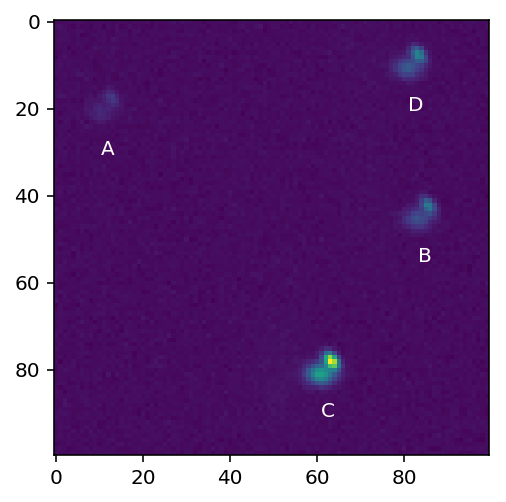

In [26]:
plt.imshow(fake_data)
for i in range(4):
    plt.text(x_c[i], y_c[i]+10, 'ABCD'[i], color='w')

Save the fake data to a numpy array.

In [27]:
!mkdir ../data

In [29]:
np.save('../data/synthetic_100x100.npy', fake_data)

Warning! Untested version!